In [128]:
# Notes for user:
# This notebook will use the US gasoline price API dataset and forex to predict the forex spot price of a currency pair.
# What to ask user before using this application:
# What currency pair are you interested in? USD/GBP (This layout means that the base currency is USD)
# The currency the user wants to look at is how much the USD is worth to the GBP.
# Therefore, we look at the price of gasoline of the US and the UK.
# So far all that is inputted is the forex price so we can understand the model
# We will need to organise US gasoline price dataset.

In [129]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-0wxjiyhg
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-0wxjiyhg
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.028e526366a3d3620adc3c375287ab71cf412bac8_-cp36-none-any.whl size=124955 sha256=5800da3cbe539fc159cea85a6ad38b675e22be5c4f7f90d5b2a5b5cdb1fe770d
  Stored in directory: /tmp/pip-ephem-wheel-cache-nkfc78nx/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [130]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
# modelling
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

#modeling metrics
from sklearn import metrics

2.2.0


# Data Collection

In [131]:
# Import forex
# Need to get the most recent dataset
forex_dataset_data= pd.read_csv('GBP_USD.csv', na_values = "?", comment='\t', skipinitialspace=True)
forex_dataset = forex_dataset_data.copy()
# forex_dataset = forex_dataset_data.dropna()
# Filter dataset


In [132]:
forex_dataset.shape

(155, 6)

In [133]:
forex_dataset.head() 
# head => starting from bottom
# tail => starting from top

,Date,Price,Open,High,Low,Change %
0,"Jul 03, 2020",1.2482,1.2466,1.2493,1.2439,0.12%
1,"Jul 02, 2020",1.2467,1.2476,1.2531,1.2456,-0.05%
2,"Jul 01, 2020",1.2474,1.2401,1.2492,1.2358,0.59%
3,"Jun 30, 2020",1.2401,1.2298,1.2402,1.2257,0.83%
4,"Jun 29, 2020",1.2299,1.2340,1.2391,1.2251,-0.30%


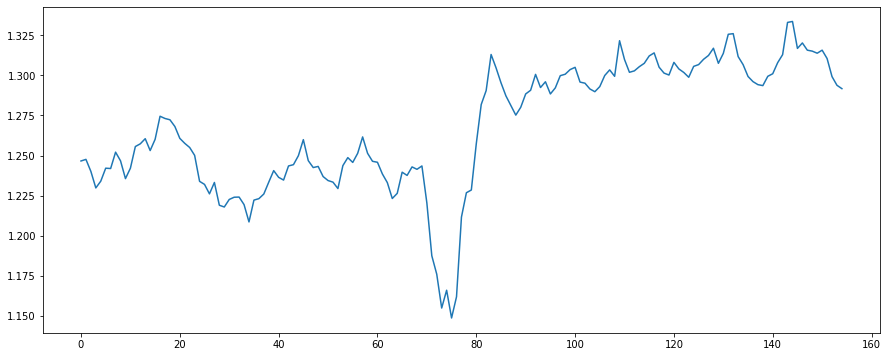

In [134]:
forex_dataset["Open"].plot()

In [135]:
!pip install EIA_python

In [136]:
import eia
import pandas as pd

def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    us_fuel_dataset = pd.DataFrame(series_search)
    return us_fuel_dataset

def main():
    """
    Run main script
    """
    #Create EIA API using your specific API key
    api_key = "a02f4b9f170de93fa421d806a4fdd23c"
    api = eia.API(api_key)
    #Declare desired series ID
    series_ID='PET.EMM_EPM0_PTE_NUS_DPG.W'
    us_fuel_dataset=retrieve_time_series(api, series_ID)
    #Print the returned dataframe us_fuel_dataset
    print(us_fuel_dataset)
    

if __name__== "__main__":
    main()


              U.S. All Grades All Formulations Retail Gasoline Prices, Weekly (Dollars per Gallon)
1993 0405 05                                              1.068                                   
1993 0412 12                                              1.079                                   
1993 0419 19                                              1.079                                   
1993 0426 26                                              1.086                                   
1993 0503 03                                              1.086                                   
...                                                         ...                                   
2020 0622 22                                              2.216                                   
2020 0629 29                                              2.260                                   
2020 0706 06                                              2.265                                   
2020 0713 

In [137]:
# confused -> why is it giving me 06/07/20 when i have 20/07/20 up there ^
us_fuel_dataset.shape

(28, 1)

In [138]:
us_fuel_dataset.head() 

,dollars_per_gallon
week_of,
06/07/2020,2.265
29/06/2020,NaN
22/06/2020,2.216
15/06/2020,2.185
08/06/2020,2.123


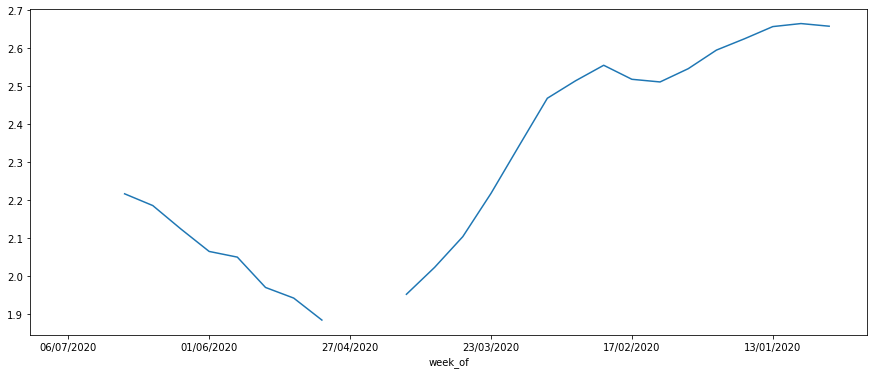

In [139]:
us_fuel_dataset["dollars_per_gallon"].plot()

In [140]:
# filter the dates you want i.e.31.12.19 - 20.07.03
# Be clear with dates so it doesnt update in the demo

# Data Preprocessing / Data Cleaning & Collating

In [152]:
# us_fuel_dataset["dollars_per_gallon"]

In [157]:
# Reset the index of dataframe
modified_us_fuel = us_fuel_dataset.reset_index()
print("Modified Dataframe : ")
print(modified_us_fuel)

Modified Dataframe : 
       week_of  dollars_per_gallon
0   06/07/2020               2.265
1   29/06/2020                 NaN
2   22/06/2020               2.216
3   15/06/2020               2.185
4   08/06/2020               2.123
5   01/06/2020               2.064
6   25/05/2020               2.049
7   18/05/2020               1.969
8   11/05/2020               1.941
9   04/05/2020               1.883
10  27/04/2020                 NaN
11  20/04/2020                 NaN
12  13/04/2020               1.951
13  06/04/2020               2.022
14  30/03/2020               2.103
15  23/03/2020               2.217
16  16/03/2020               2.343
17  09/03/2020               2.468
18  02/03/2020               2.514
19  24/02/2020               2.555
20  17/02/2020               2.518
21  10/02/2020               2.511
22  03/02/2020               2.546
23  27/01/2020               2.595
24  20/01/2020               2.625
25  13/01/2020               2.657
26  06/01/2020               2.66

In [164]:
# Create a method that adds a new date to  us_fuel_dataset every week:
# for every_week in us_fuel_dataset:
#   create 6 new columns and rows under this row
#   fill them with the values that is the date and fuel price
# return new_us_fuel_date_dataframe



New row added to DataFrame
--------------------------
       week_of dollars_per_gallon
0   06/07/2020              2.265
1   29/06/2020                NaN
2   22/06/2020              2.216
3   15/06/2020              2.185
4   08/06/2020              2.123
5   01/06/2020              2.064
6   25/05/2020              2.049
7   18/05/2020              1.969
8   11/05/2020              1.941
9   04/05/2020              1.883
10  27/04/2020                NaN
11  20/04/2020                NaN
12  13/04/2020              1.951
13  06/04/2020              2.022
14  30/03/2020              2.103
15  23/03/2020              2.217
16  16/03/2020              2.343
17  09/03/2020              2.468
18  02/03/2020              2.514
19  24/02/2020              2.555
20  17/02/2020              2.518
21  10/02/2020              2.511
22  03/02/2020              2.546
23  27/01/2020              2.595
24  20/01/2020              2.625
25  13/01/2020              2.657
26  06/01/2020            

In [ ]:
#Able to insert at the end of dataframe

#create dataframe
df_marks = pd.DataFrame(modified_us_fuel)
# print('Original DataFrame\n------------------')
# print(df_marks)

new_row = {'week_of':'new_day','dollars_per_gallon':'new_price' }
#append row to the dataframe
df_marks = df_marks.append(new_row, ignore_index=True)

print('\n\nNew row added to DataFrame\n--------------------------')
print(df_marks)

In [185]:
#modified_us_fuel.loc[-1] = ['06/07/2020', 2.265]  # adding a row
#modified_us_fuel.index = modified_us_fuel.index + 1  # shifting index
#modified_us_fuel = modified_us_fuel.sort_index()
#modified_us_fuel

price = modified_us_fuel['week_of'].values[0]
print(price)

06/07/2020


In [183]:
# need to change 2020-07-03 to fit closer to forex time 
# create a new table line up the prices with the new dates
s = pd.date_range('2019-12-30', '2020-07-03', freq='D').to_series()
s.dt.dayofweek

2019-12-31    1
2020-01-01    2
2020-01-02    3
2020-01-03    4
2020-01-04    5
             ..
2020-06-29    0
2020-06-30    1
2020-07-01    2
2020-07-02    3
2020-07-03    4
Freq: D, Length: 186, dtype: int64

In [142]:
# Isolate us_gas week_of collumn
import time 
us_date = us_fuel_dataset['week_of']
new_us_dates = [time.strptime(x.replace("-"," "), '%d %m %Y')for x in us_date]
us_fuel_dataset['week_of'] = new_us_dates
us_death_rates.head()

KeyError: ignored

In [ ]:
# Isolate forex_date
import time 
forex_date = forex_dataset['Date']
new_forex_dates = [time.strptime(x.replace(',', ""), '%b %d %Y')for x in forex_date]
forex_dataset['Date'] = new_forex_dates
forex_dataset.tail()

In [ ]:
print(len(forex_dataset))
print(len(us_fuel_dataset))

In [ ]:
# Merging dates from two tables
dataset = pd.merge(left=forex_dataset, left_on='Date',
         right=us_death_rates, right_on='week_of')
dataset.tail()
len(dataset)

In [ ]:
dataset.tail()

# Sample Features - Go Over


In [ ]:
# Look back last 4 days
# X variables/ features that we care about
# Y variable/ output/ what we want to predict
window_size=12
num_samples=len(forex_dataset)-window_size

# Get indices of access for the data
indices=np.arange(num_samples).astype(np.int)[:,None]+np.arange(window_size+1).astype(np.int)

data = forex_dataset["Open"].values[indices] # Create the 2D matrix of training samples
x = data[:,:-1] # Each row represents 12 days in the past
y = data[:,-1] # Each output value represents the 13rd day

In [ ]:
# not data frame anymore now it is a list
# forex_dataset.head() of it
x

In [ ]:
y

In [ ]:
# 80% of my data
split_fraction=0.8
ind_split=int(split_fraction*num_samples)

In [ ]:
# x features and y features
# test and train
x_train = x[:ind_split]
y_train = y[:ind_split]
x_test = x[ind_split:]
y_test = y[ind_split:]

In [ ]:
x_train.shape, x_test.shape

In [ ]:
y_train.shape, y_test.shape

# Modelling

In [ ]:
# Help Functions
# Need to consider the trade offs between the models you use
def get_performance (model_pred):
  #Function returns standard performance metrics
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, model_pred).round(4))  
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, model_pred).round(4))  
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, model_pred)).round(4))
  
  
  
def get_plot (model_pred):
  plt.scatter(model_pred, y_test, color="gray")
  plt.plot(y_test, y_test, color='red', linewidth=2)

# Baseline

In [ ]:
# let your prediction be the most recent observation
# looking at the one day previous 
# np.roll-> similar to shift for a dataframe
y_pred_lag=np.roll(y_test,1)

In [ ]:
# np.roll(y,1)

In [ ]:
# any has to be better than this
# performance reltive to that very simlpe approach
get_performance(y_pred_lag)

In [ ]:
# red line is the perfect prediction
get_plot(y_pred_lag)

# Linear Regression

In [ ]:
# assigning the linear regression model
model_lr=LinearRegression()
# fitting the linear regression model to xtrain, xytrain
model_lr.fit(x_train, y_train)

In [ ]:
#help
# ?model_lr.fit()

In [ ]:
# x variable and predict the y 
y_pred_lr=model_lr.predict(x_test)

In [ ]:
# check how they compare to the baseline
# not a big difference at all only in root mean
# not great
get_performance(y_pred_lr)

In [ ]:
get_plot(y_pred_lr)

In [ ]:
get_performance(y_pred_lr)

In [ ]:
# this should list our 12 co-efficients for all of our variables
# most recent day: 1.18024445
# as you can see other values are - and small, this is why the baseline 
# is so good because the previous day is the msot important value
# change is marginal
# only focus on the the last one
# problem: only print the last output
model_lr.coef_

# Method #1- Ridge Regression

In [ ]:
model_ridge = Ridge()
model_ridge.fit(x_train, y_train)

#generate predictions
y_pred_ridge=model_ridge.predict(x_test)

In [ ]:
# look at difference in baseline and ridge regression
# trying to figure out which one of the features is the most prominent
get_performance(y_pred_ridge)

In [ ]:
get_plot(y_pred_ridge)

In [ ]:
# this should list our 12 co-efficients for all of our variables
# most recent day: 0.09432427
# change is marginal
# only focus on the the last one
# problem: only print the last output
# limit the number of days your looking back
# what is the trend: higher/lower?
# keep same features but apply different features
# k folds cross validation? in terms of splitting the data
model_ridge.coef_

# Gradient Boosting Trees

In [ ]:
# Model #2 - Gradient Boosting Trees
# not linear, tree based
model_gb = GradientBoostingRegressor()
model_gb.fit(x_train, y_train)

# Infer
y_pred_gb = model_gb.predict(x_test)

In [ ]:
get_performance(y_pred_gb)

In [ ]:
# Why cant I print dates on the bottom of my graph?
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

get_plot(y_pred_gb)
# plt.plot(y_pred_gb)
plt.title('Gradient Boosting Model of US & USD/GBP')
plt.xlabel('Date')
plt.ylabel('Price')
# dates = np.array(dateFormatting['Date'])
# plt.plot_date(dates,y_pred_gb, linestyle ='solid')

# Comparison

In [ ]:
# absolute -> only have positives
df_comp=pd.DataFrame({"lag":np.absolute(y_test-y_pred_lag), 
              "lr":np.absolute(y_test-y_pred_lr), 
              "ridge":np.absolute(y_test-y_pred_ridge),
              "gb":np.absolute(y_test-y_pred_gb)})

In [ ]:
df_comp.head()

In [ ]:
# go over again 51:22
y_pred_lag

In [ ]:
#
df_comp.plot.bar(figsize=(16, 6))
# show me days 0 to 10
plt.xlim(11,20)
# unsure why this line doesnt work
# plt.ylim(0,10)

# Conclusion and next steps

Explored 4 different algorithms, ranging from simple to complex:


*   Lag (Previous day's price)
*   Linear Regression 
*   Ridge Regression
*   Gradient Boosting Trees

In conclusion it seems that Linear Regression gives us the best performance with the least complexity. Next steps might include adding additional features such as trend and recent volatility (go over).


